# NN 실습 (MNEST datasets)

MNIST : 0~9 손글씨 숫자 분류

In [ ]:
''' import '''
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T

# data proc
import numpy as np
import itertools

import matplotlib.pyplot as plt

In [32]:
''' constant '''
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

In [31]:
''' num of model param '''
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Confusion matrix
Prediction 평가 지표 -> 예측 value와 실제 value를 비교하기 위한 표

| Actual \ Predict | Positive | Negative |
|-----------------|----------|----------|
| **Positive**    | TP       | FN       |
| **Negative**    | FP       | TN       |

의료에서 FP가 위험

`TP` (True Positive): 실제 P, 예측 P  
`FN` (False Negative): 실제 P, 예측 N  
`FP` (False Positive): 실제 N, 예측 P  
`TN` (True Negative): 실제 N, 예측 N  

In [ ]:
''' plot confusion matrix '''
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    error = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(20,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max()/1.5 if normalize else cm.max()/2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j,i, '{:0.3f}'.format(cm[i,j]), 
                         horizontalalignment='center',
                         color='white' if cm[i,j] > thresh else 'black')
            else:
                plt.text(j,i, '{:,}'.format(cm[i,j]), 
                         horizontalalignment='center',
                         color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label\naccuracy={:0.4f}: misclass={:0.4f}'.format(accuracy, error))
    plt.show()

## DataLoader
dataset -> dataloader : add batch, transforms

- batch_size : 2의 배수(for GPU memory utilization), the larger the better

In [ ]:
''' create dataloader '''
def MNIST_Data(root='./data', train=True, transforms=None, download=True, batch_size=32, num_worker=1):
    print('[+] Get the MNIST DATA')

    # dataset
    mnist_train = datasets.MNIST(root=root,
                                     train=True,
                                     transform=T.ToTensor(), # data -> tensor
                                     download=download)
    mnist_test = datasets.MNIST(root=root,
                                    train=False,
                                    transform=T.ToTensor(),
                                    download=download)
    
    # data loader : iterator for batch 단위 학습
    trainDataLoader = data.DataLoader(dataset=mnist_train,
                                      batch_size=batch_size,
                                      shuffle=True,             # default=class별, 다양한 클래스 랜덤으로
                                      num_workers=num_worker)    # cpu 코어수 비례 (1 or 4)
    testDataLoader = data.DataLoader(dataset=mnist_test,
                                     batch_size=batch_size,
                                     shuffle=False,             # test는 필요없
                                     num_workers=num_worker)
    
    print('[+] Finished loading data & Preprocessing')
    return mnist_train, mnist_test, trainDataLoader, testDataLoader

In [7]:
# data loader
trainDset, testDset, trainDloader, testDloader = MNIST_Data(batch_size=32, num_worker=4)

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


In [8]:
trainDset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
trainDset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [10]:
trainDset.data.shape

torch.Size([60000, 28, 28])

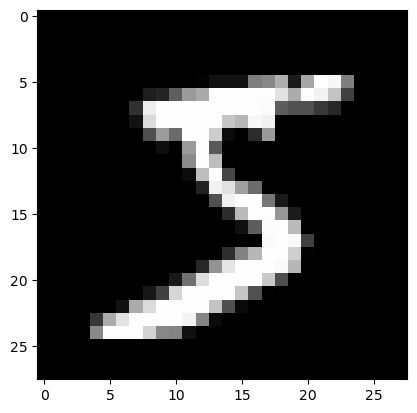

In [11]:
plt.imshow(trainDset.data[0], cmap='gray')

In [13]:
data = next(iter(trainDloader))
print(data[0].shape, data[1].shape) # image, label

torch.Size([32, 1, 28, 28]) torch.Size([32])


## Define Trainer

Trainer class : net, trainLoader, testLoader, optimizer, criterion을 input으로 받아, 학습/평가 진행

In [ ]:
''' trainer for all '''
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, epoch=1):
        self.net.train() # train mode
        for e in range(epoch):

            train_loss = 0.0

            for i, data in enumerate(self.trainloader): # start=0
                # input, label
                inputs, labels = data[0], data[1]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward + backward + optimize(step)
                self.optimizer.zero_grad()

                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                
                loss.backward()
                self.optimizer.step()

                # print statistics
                train_loss += loss.item()
                if (i+1) % 500 == 0:
                    print('[%d, %5d] loss: %.3f' % (e+1, i+1, train_loss/500))
                    train_loss = 0.0
        
        
        print('Finished Training')

    def test(self):
        self.net.eval() # test moe

        num_data = len(self.testloader.dataset)
        test_loss = 0.0
        correct = 0

        for inputs, labels in self.testloader:
            # input, label
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            output = self.net(inputs)
            loss = self.criterion(output, labels)

            pred = output.max(1, keepdim=True)[1] # get the index of the max
            test_loss += loss.item()
            correct += pred.eq(labels.view_as(pred)).sum().item()

        test_loss /= num_data
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, 
                                                               num_data,
                                                               (correct/num_data)*.100))

    def get_conf(self):
        self.net.eval()

        confusion = torch.zeros(10,10)
        for inputs, labels in self.testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = self.net(inputs)
            pred = torch.argmax(output, dim=1)

            for num in range(output.shape[0]):
                confusion[pred[num], labels[num]] += 1
                
        return confusion

## Network

### (1) 2-Layer Net + Sigmoid
- input : 28*28
- hidden dim : 30
- ouput dim : 10
- activation fn : sigmoid
- optimizer : SGD
- loss : CE

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(-1, 28*28)   # (batch, 28, 28) -> (batch, 28*28)
        x = self.fc0(x) # 28*28 -> 30
        x = self.act(x)
        x = self.fc1(x) # 30 -> 10      # +++ soft max는 CE에서 자동 적용
        return x

In [ ]:
# model
mnist_net = MNIST_Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader=trainDloader,
                  testloader=testDloader,
                  net=mnist_net,
                  criterion=criterion,
                  optimizer=optimizer)

In [ ]:
# train
trainer.train(epoch=10)

[1,   500] loss: 2.330
[1,  1000] loss: 2.303
[1,  1500] loss: 2.285
[2,   500] loss: 2.261
[2,  1000] loss: 2.248
[2,  1500] loss: 2.236
[3,   500] loss: 2.213
[3,  1000] loss: 2.199
[3,  1500] loss: 2.185
[4,   500] loss: 2.159
[4,  1000] loss: 2.142
[4,  1500] loss: 2.124
[5,   500] loss: 2.092
[5,  1000] loss: 2.070
[5,  1500] loss: 2.051
[6,   500] loss: 2.012
[6,  1000] loss: 1.989
[6,  1500] loss: 1.969
[7,   500] loss: 1.922
[7,  1000] loss: 1.898
[7,  1500] loss: 1.872
[8,   500] loss: 1.825
[8,  1000] loss: 1.801
[8,  1500] loss: 1.772
[9,   500] loss: 1.722
[9,  1000] loss: 1.698
[9,  1500] loss: 1.673
[10,   500] loss: 1.626
[10,  1000] loss: 1.604
[10,  1500] loss: 1.573
Finished Training


In [ ]:
# test
trainer.test()


Test set: Accuracy: 6958/10000 (70%)



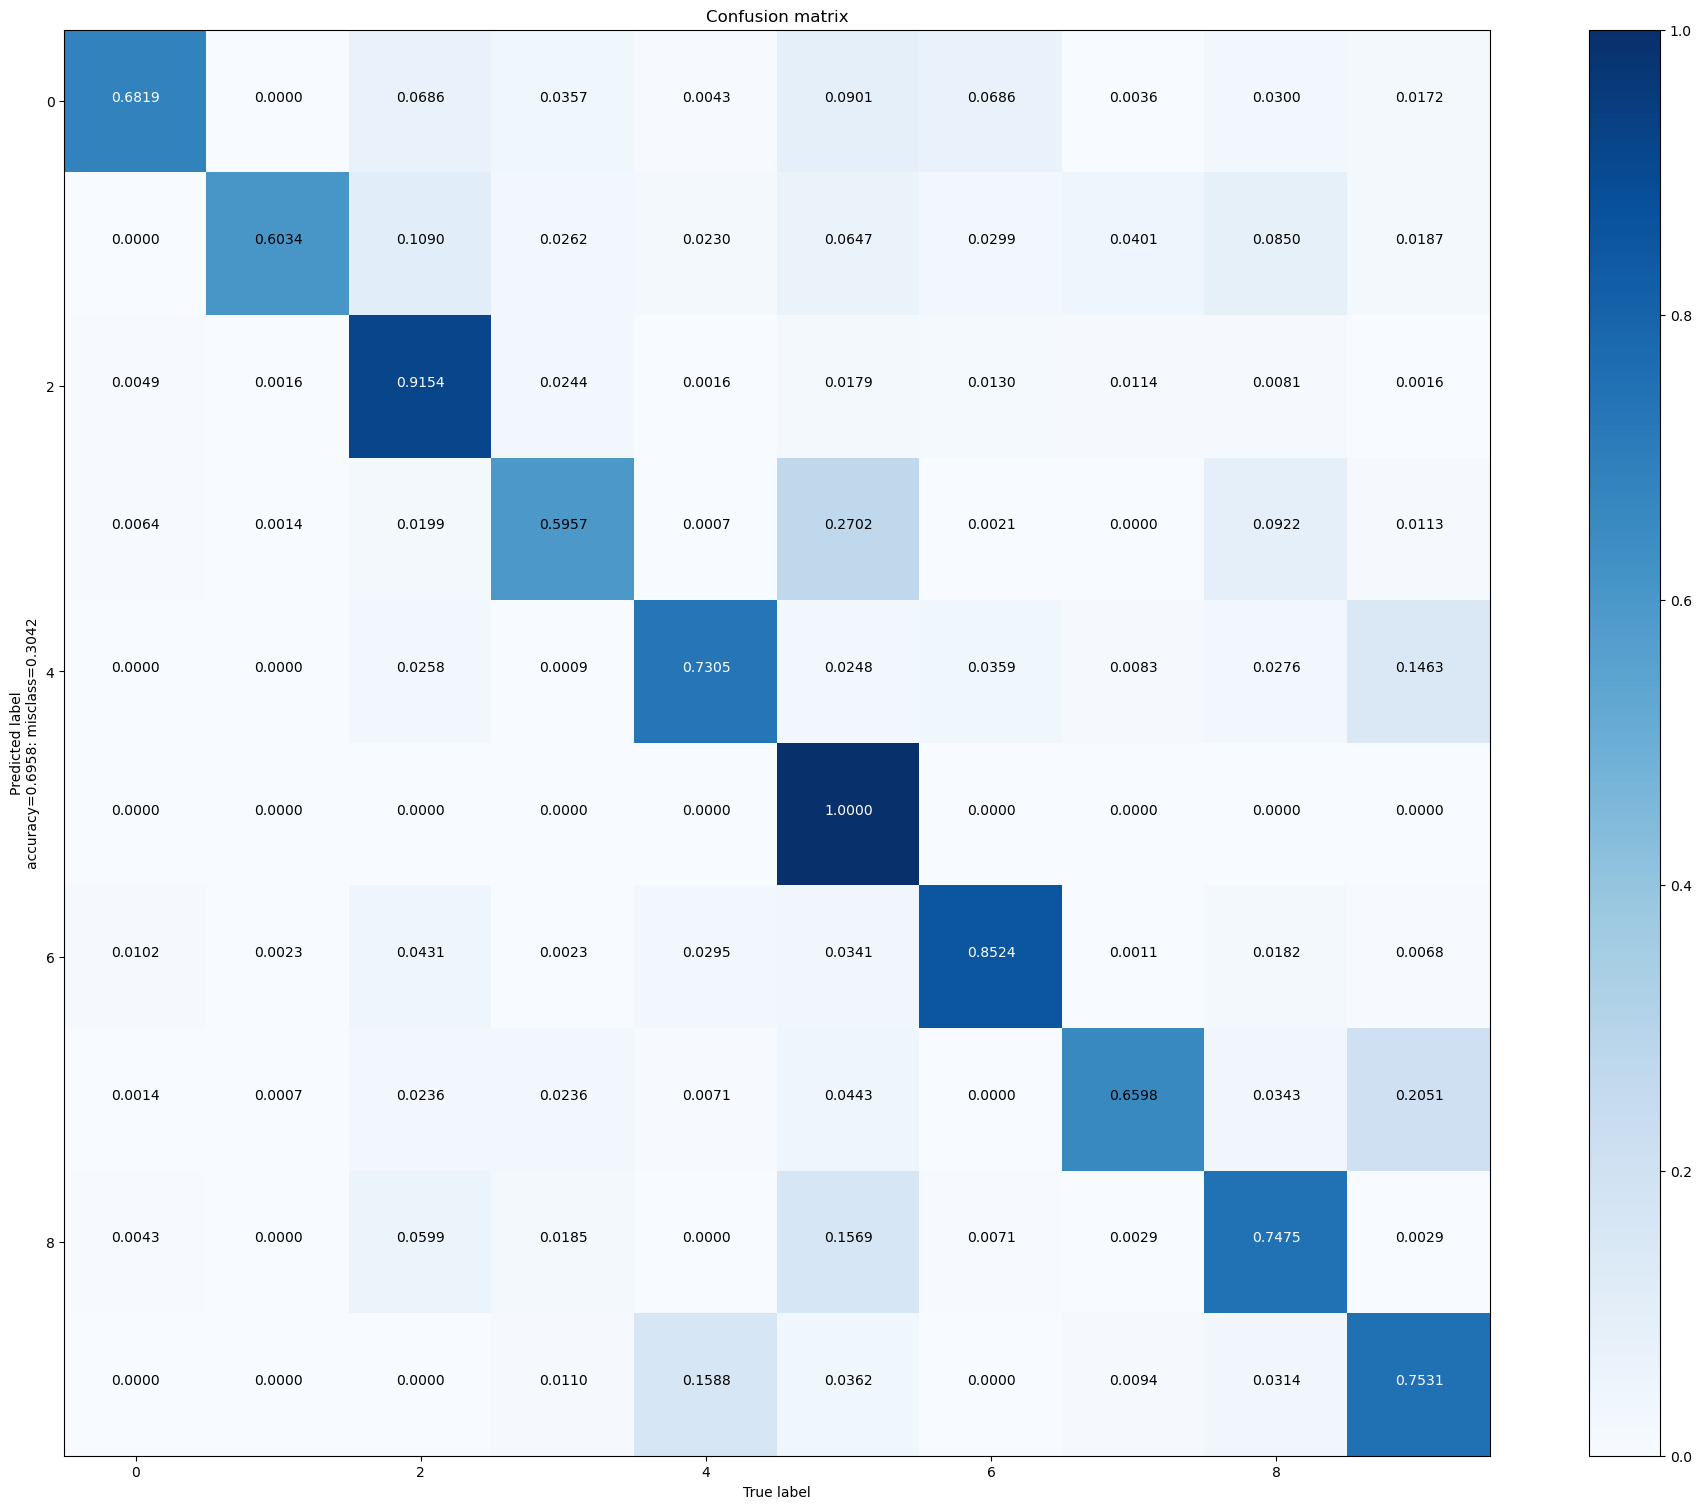

In [23]:
plot_confusion_matrix(trainer.get_conf().numpy())

### (1) 2-Layer Net + ReLU
- input : 28*28
- hidden dim : 30
- ouput dim : 10
- activation fn : relu
- optimizer : SGD
- loss : CE

수렴속도가 빠름, loss가 극적으로 떨어짐

In [24]:
class MNIST_Net_ReLU(nn.Module):
    def __init__(self):
        super(MNIST_Net_ReLU, self).__init__()
        self.fc0 = nn.Linear(28*28, 30)
        self.fc1 = nn.Linear(30, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.fc0(x)
        x = self.act(x)
        x = self.fc1(x)
        return x

In [ ]:
# model
mnist_net_relu = MNIST_Net_ReLU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mnist_net_relu.parameters(), lr=0.001)

In [26]:
trainer_relu = Trainer(trainloader=trainDloader,
                  testloader=testDloader,
                  net=mnist_net_relu,
                  criterion=criterion,
                  optimizer=optimizer)

In [ ]:
# train
trainer_relu.train(epoch=10)

[1,   500] loss: 2.255
[1,  1000] loss: 2.155
[1,  1500] loss: 2.038
[2,   500] loss: 1.810
[2,  1000] loss: 1.663
[2,  1500] loss: 1.520
[3,   500] loss: 1.276
[3,  1000] loss: 1.158
[3,  1500] loss: 1.063
[4,   500] loss: 0.926
[4,  1000] loss: 0.861
[4,  1500] loss: 0.805
[5,   500] loss: 0.739
[5,  1000] loss: 0.698
[5,  1500] loss: 0.677
[6,   500] loss: 0.634
[6,  1000] loss: 0.612
[6,  1500] loss: 0.598
[7,   500] loss: 0.579
[7,  1000] loss: 0.555
[7,  1500] loss: 0.527
[8,   500] loss: 0.526
[8,  1000] loss: 0.507
[8,  1500] loss: 0.496
[9,   500] loss: 0.482
[9,  1000] loss: 0.473
[9,  1500] loss: 0.472
[10,   500] loss: 0.459
[10,  1000] loss: 0.450
[10,  1500] loss: 0.448
Finished Training


In [ ]:
# test
trainer_relu.test()


Test set: Accuracy: 8895/10000 (89%)



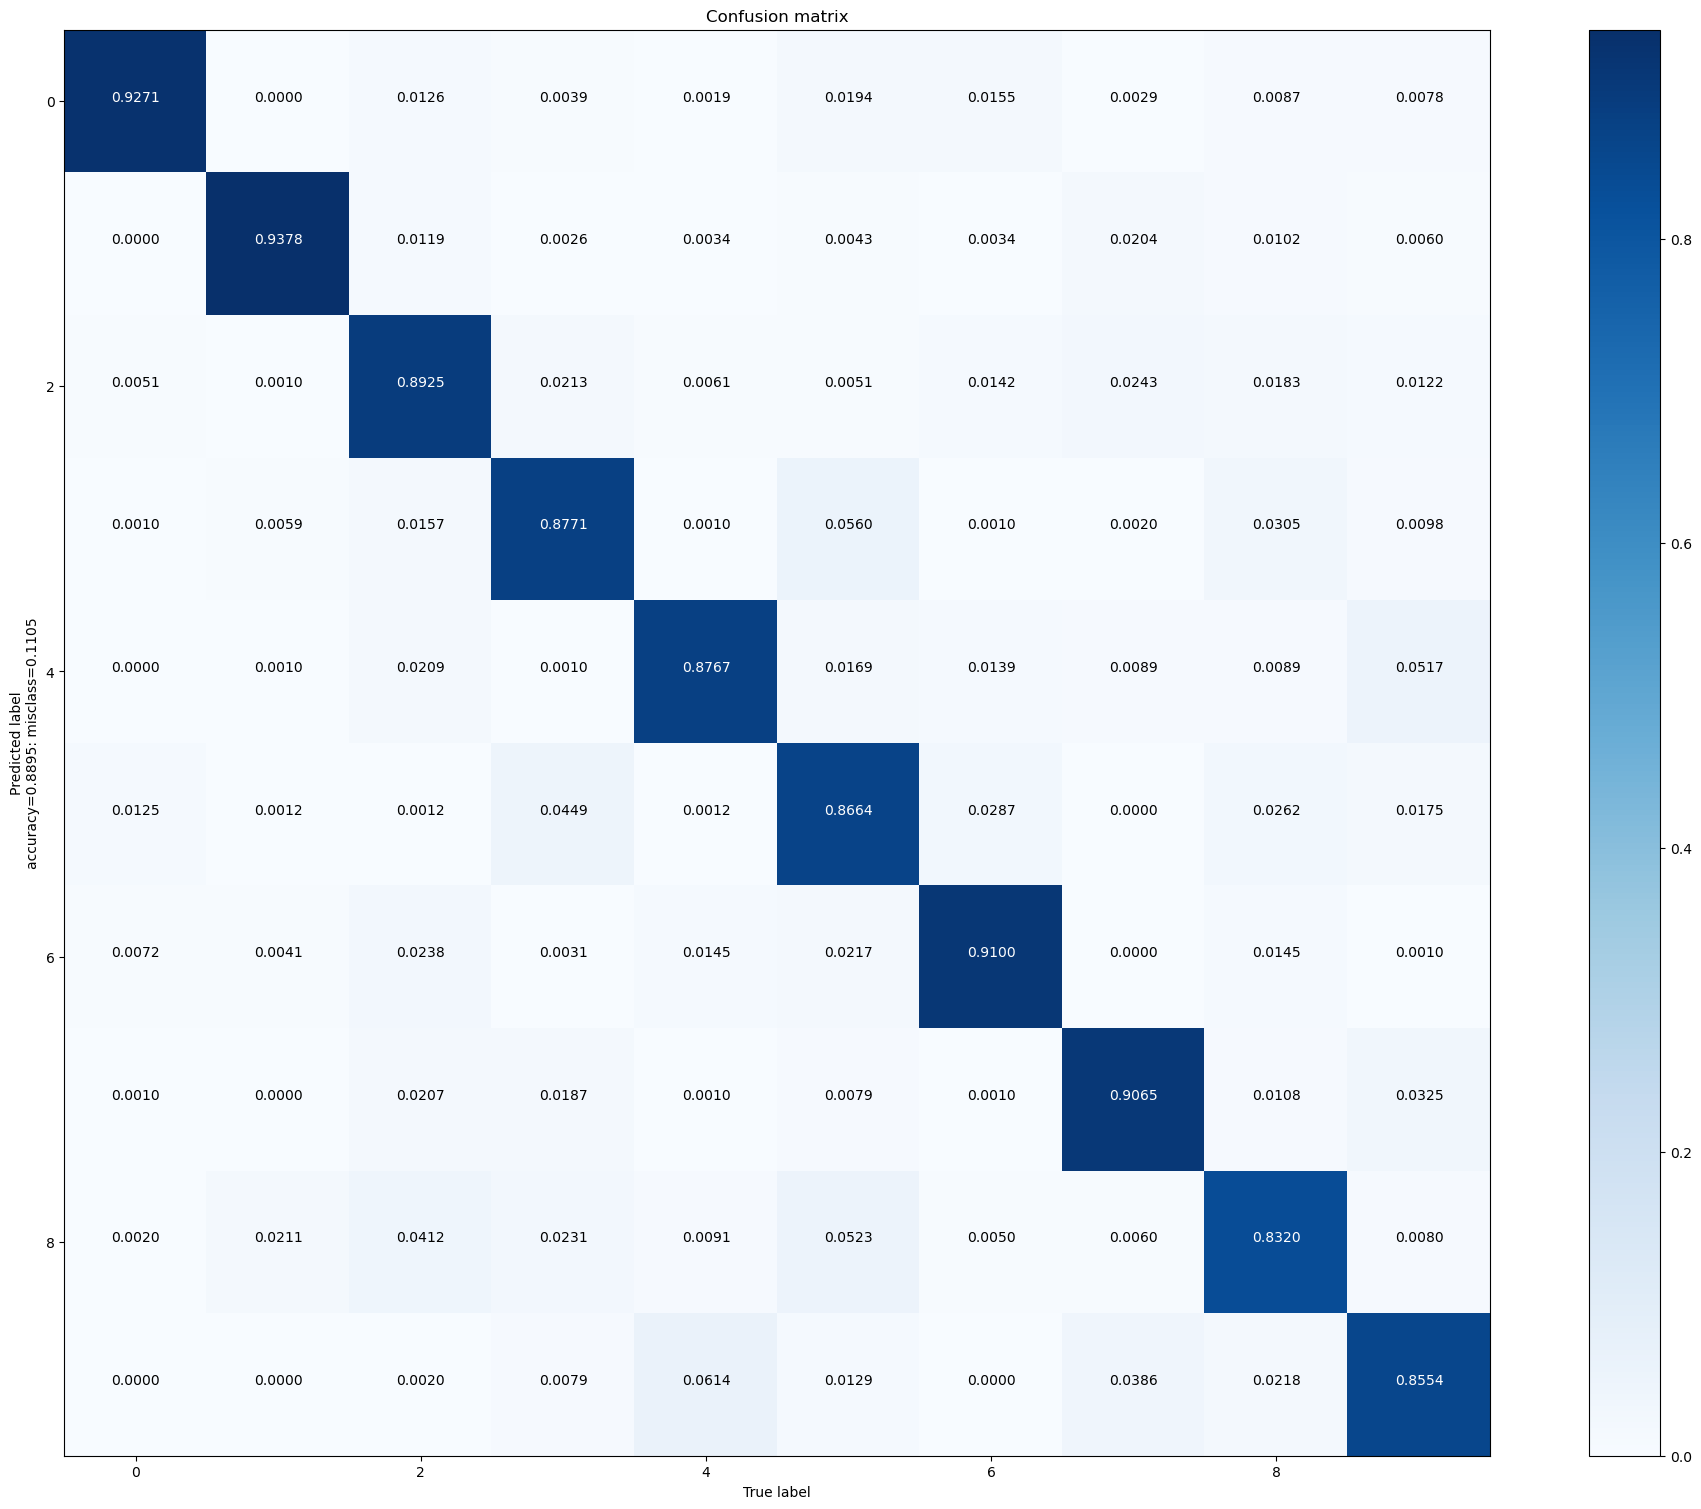

In [29]:
plot_confusion_matrix(trainer_relu.get_conf().numpy())